In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import time
import calendar
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
import calendar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score,confusion_matrix
import itertools
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
%matplotlib inline
%time
%autonotify -a 30

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<IPython.core.display.Javascript object>

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


# EDA
### Exploratory Data Analysis

In [2]:
df=pd.read_csv("https://s3.us-east-2.amazonaws.com/marklabs-yoniplayground/AAS/aac_shelter_outcomes.csv")

In [3]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
df.tail()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female
78255,2 months,A765857,Dog,Labrador Retriever Mix,White/Brown,2017-11-13T00:00:00,2018-02-01T18:44:00,2018-02-01T18:44:00,NaN,NaN,Adoption,Neutered Male


In [5]:
df.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [6]:
df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


In [7]:
df.nunique()

age_upon_outcome       46
animal_id           70855
animal_type             5
breed                2128
color                 525
date_of_birth        5869
datetime            64361
monthyear           64361
name                14574
outcome_subtype        19
outcome_type            9
sex_upon_outcome        5
dtype: int64

In [8]:
df=df.drop(['outcome_subtype','animal_id','datetime'],axis=1)

In [9]:
df=df[df.animal_type!="Other"]

In [10]:
df=df.dropna(subset=['age_upon_outcome',"outcome_type","sex_upon_outcome"])

In [11]:
df=df.drop_duplicates()

In [12]:
animal_dummy=pd.DataFrame(pd.get_dummies(df.animal_type))
df=pd.concat([df,animal_dummy],axis=1)

In [13]:
df['age_upon_outcome']=[i.strip('s') for i in df.age_upon_outcome]

In [14]:
mult=[]
for i in df.age_upon_outcome:
    if "week" in i.lower():
        mult.append(.26)
    if "month" in i.lower():
        mult.append(1)
    if "year" in i.lower():
        mult.append(12)
    if "day" in i.lower():
        mult.append(.0333)
        
        
    

In [15]:
df['mult']=mult

In [16]:
def stripnum(data):
    return re.findall(r'\d+', data)

df['age_upon_outcome']=df.age_upon_outcome.apply(stripnum).astype(str).str.replace('\[|\]|\'', '')

df['age_upon_outcome']=pd.to_numeric(df.age_upon_outcome,errors='coerce')

df['age_upon_outcome']=df.age_upon_outcome.astype(float)

df['age_months']=df['age_upon_outcome']*df['mult'].astype(int)

In [17]:
# df=df.drop(['age_upon_outcome','mult','animal_type'],axis=1)

# Visualizations

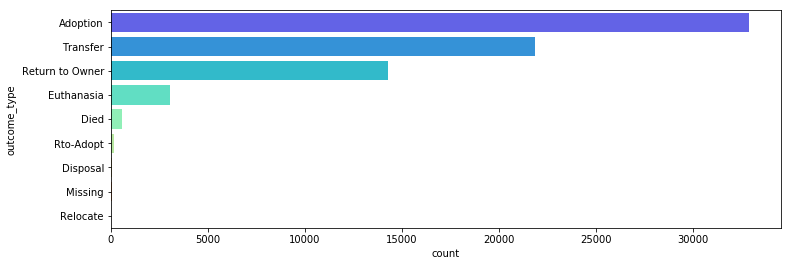

In [18]:
plt.figure(figsize=(12,4))
sns.countplot(y=df['outcome_type'], 
              palette='rainbow',
              order=df['outcome_type'].value_counts().index)

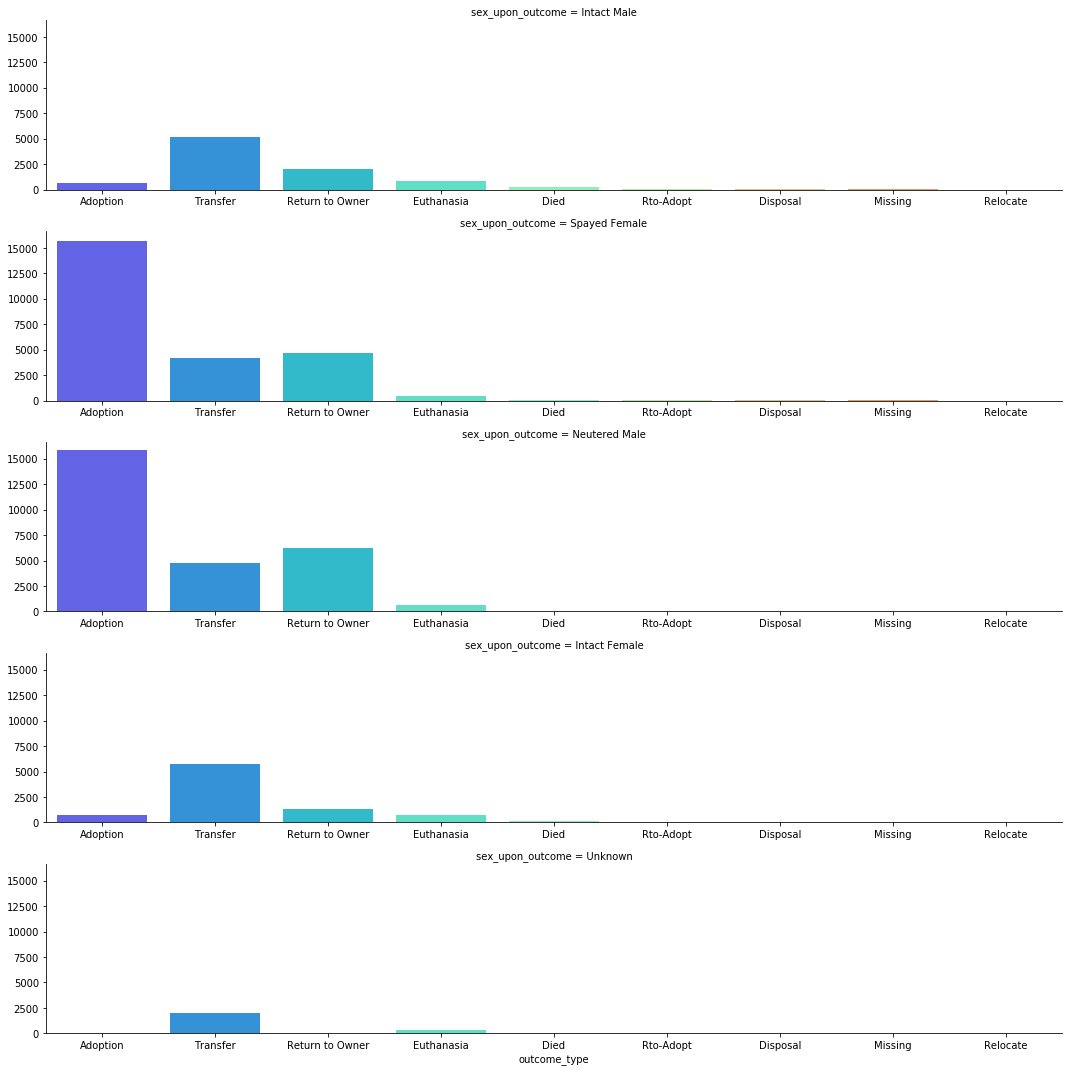

In [19]:
g = sns.FacetGrid(df, row='sex_upon_outcome', aspect=5, sharex=False)
g.map(sns.countplot, 'outcome_type', palette='rainbow',order=df['outcome_type'].value_counts().index)

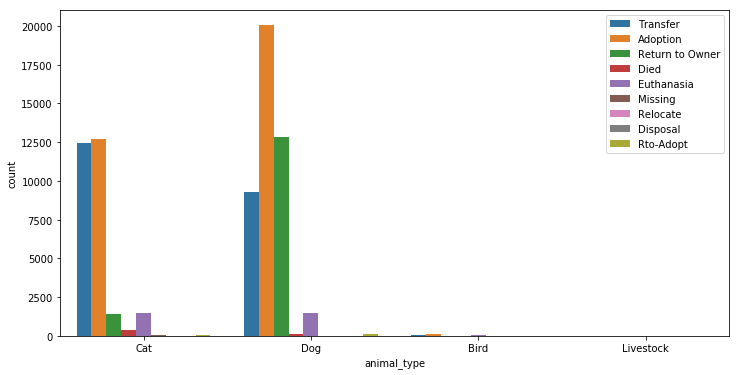

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,
              x='animal_type',
              hue='outcome_type')
plt.legend(loc='upper right')


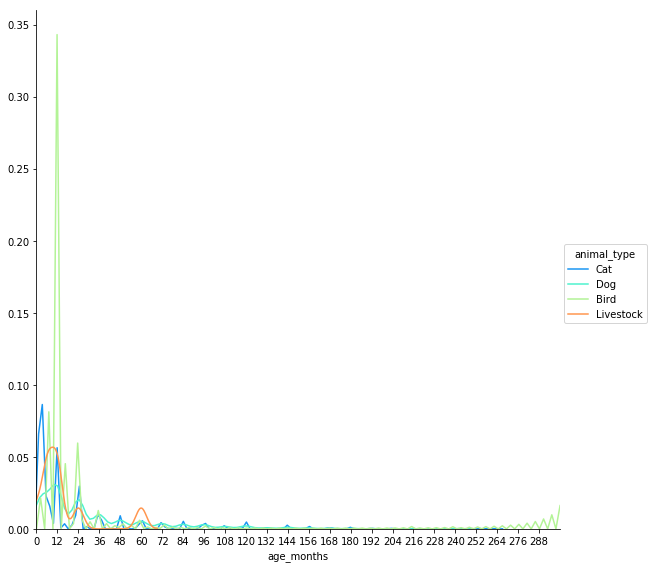

In [21]:
g = sns.FacetGrid(df, hue="animal_type", size=8,palette='rainbow')
g.map(sns.kdeplot, "age_months") 
g.add_legend()
g.set(xlim=(0,300), xticks=range(0,300,12))
plt.show(g)

In [22]:
df[(df['animal_type']=='Bird') & (df['age_months']>200)]
# df[(df['column_one']>2004) & (df['column_two']==9)]

,age_upon_outcome,animal_type,breed,color,date_of_birth,monthyear,name,outcome_type,sex_upon_outcome,Bird,Cat,Dog,Livestock,mult,age_months
50245,18.0,Bird,Parrot Mix,Gray/Red,1998-03-12T00:00:00,2016-03-12T19:07:00,Basil,Adoption,Intact Male,1,0,0,0,12.0,216.0
52190,20.0,Bird,Cockatoo,White/Orange,1996-12-11T00:00:00,2016-12-16T00:00:00,Sunny,Transfer,Intact Male,1,0,0,0,12.0,240.0
62915,25.0,Bird,Cockatoo,White/Orange,1991-12-11T00:00:00,2016-12-16T00:00:00,Sweet Pea,Transfer,Intact Female,1,0,0,0,12.0,300.0


Cockatoos have a life span of 50 to 70 years. 

In [23]:
df[df.animal_type=="Bird"].describe()

,age_upon_outcome,Bird,Cat,Dog,Livestock,mult,age_months
count,312.000000,312.0,312.0,312.0,312.0,312.000000,312.000000
mean,2.320513,1.0,0.0,0.0,0.0,9.214295,15.932692
std,2.557348,0.0,0.0,0.0,0.0,4.877916,26.332623
min,1.000000,1.0,0.0,0.0,0.0,0.033300,0.000000
25%,1.000000,1.0,0.0,0.0,0.0,12.000000,12.000000
50%,1.000000,1.0,0.0,0.0,0.0,12.000000,12.000000
75%,2.000000,1.0,0.0,0.0,0.0,12.000000,12.000000
max,25.000000,1.0,0.0,0.0,0.0,12.000000,300.000000


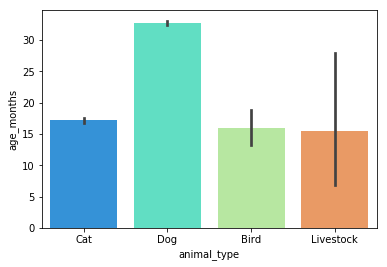

In [24]:
sns.barplot(df.animal_type,df.age_months,palette='rainbow')

In [25]:
df=df.drop(['age_upon_outcome','mult'],axis=1)
        

In [26]:
df['monthyear']=df['monthyear'].astype('datetime64[M]')


In [27]:
adopted=df[df.outcome_type=="Adoption"]


In [28]:
animals=adopted.animal_type.unique()
dicti={}
for item in animals:
    dicti[item]=(adopted[adopted['animal_type']==item].groupby("monthyear").animal_type.count())

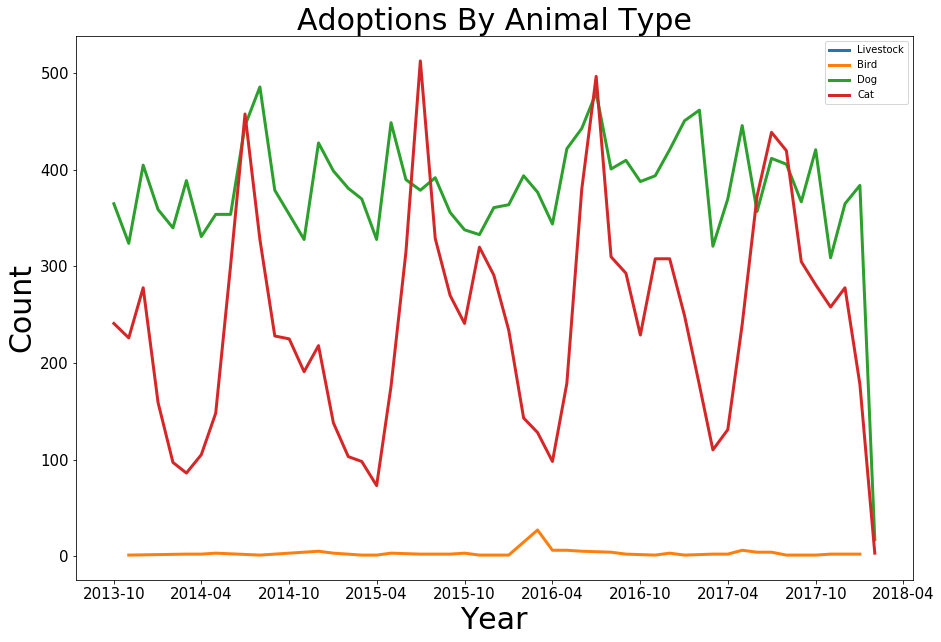

In [29]:
plt.figure(figsize=(15,10))

for animal in dicti.values():
   x = animal.keys()
   y = animal.values
   plt.title("Adoptions By Animal Type",fontsize=30)
   plt.xlabel("Year",fontsize=30)
   plt.ylabel("Count", fontsize=30)
   plt.tick_params(axis='both', which='major', labelsize=15)
   plt.tick_params(axis='both', which='minor', labelsize=15)
   plt.plot(x,y,linewidth=3)
   
   


plt.legend(dicti.keys(),prop={'size': 10})

In [30]:
df.columns

Index([u'animal_type', u'breed', u'color', u'date_of_birth', u'monthyear',
       u'name', u'outcome_type', u'sex_upon_outcome', u'Bird', u'Cat', u'Dog',
       u'Livestock', u'age_months'],
      dtype='object')

# Feature Engineering/Preprocessing
### Creating Features From Our Data

In [31]:
NotOKlist = ('Mix',"""/""")
mix=[]
for item in df.breed:
    if any(s in item for s in NotOKlist):
        mix.append(1)
    else:
        mix.append(0)

In [32]:
df['mix_dummy']=mix

In [33]:
df.outcome_type.value_counts()

Adoption           32861
Transfer           21849
Return to Owner    14297
Euthanasia          3032
Died                 543
Rto-Adopt            150
Disposal              55
Missing               46
Relocate               7
Name: outcome_type, dtype: int64

In [34]:
def test_re(s):
    return re.sub("/",' ',s)

In [35]:
df['color']=df.color.apply(test_re)

In [36]:
onehot=LabelBinarizer()
x=pd.DataFrame(onehot.fit_transform(df.sex_upon_outcome),columns=onehot.classes_)
df.reset_index(drop=True,inplace=True)


In [37]:
df=pd.concat([df,x],axis=1)

# NLP
### Natural Language Processing

In [38]:
cvec = CountVectorizer( min_df=5, stop_words='english')

cvec.fit(df['breed'])

cvecdata= cvec.transform(df['breed'])

titlewords = cvecdata.toarray()

vocab = cvec.get_feature_names()

titlewords= pd.DataFrame(titlewords,columns=cvec.get_feature_names())

In [39]:
cvec = CountVectorizer( min_df=5, stop_words='english')

cvec.fit(df['color'])

cvecdata= cvec.transform(df['color'])

titlewords2 = cvecdata.toarray()

vocab2 = cvec.get_feature_names()

titlewords2= pd.DataFrame(titlewords2,columns=cvec.get_feature_names())

In [40]:
df=pd.concat([df,titlewords,titlewords2],axis=1)

In [41]:
df['month']=df.monthyear.dt.month
df['day']=df.monthyear.dt.dayofweek

In [42]:
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
df['day'] = df['day'].apply(lambda x: calendar.day_name[x])

In [43]:
df_dummies = pd.get_dummies(df[['month','day']])
df=pd.concat([df,df_dummies],axis=1)

In [44]:
puppykittendummy=[]
for animal in df.age_months:
    if animal <= 12.0:
        puppykittendummy.append(1)
    else:
        puppykittendummy.append(0)
df['puppykitten']=puppykittendummy        

In [45]:
dfm=df.drop(['breed','color','date_of_birth','name','monthyear','sex_upon_outcome','month','day'],axis=1)

In [46]:
dfm=dfm[(dfm['animal_type']=='Dog') | (dfm['animal_type']=='Cat')]
dfm=dfm[(dfm['outcome_type']=='Adoption') | (dfm['outcome_type']=='Transfer')]

In [47]:
dfm=dfm.drop(['animal_type','Bird','Livestock'],axis=1)
dfm.reset_index(drop=True,inplace=True)

In [48]:
X = dfm[dfm.columns[1:]]
y= dfm.outcome_type
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=.3,stratify=dfm.outcome_type)

In [49]:
%%time
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

CPU times: user 300 ms, sys: 340 ms, total: 640 ms
Wall time: 637 ms


# Feature Selection and Model Building

In [50]:
%%time
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True,n_jobs=-1)

rf_classifier.fit(X_train, y_train)

CPU times: user 45.9 s, sys: 920 ms, total: 46.8 s
Wall time: 9.65 s


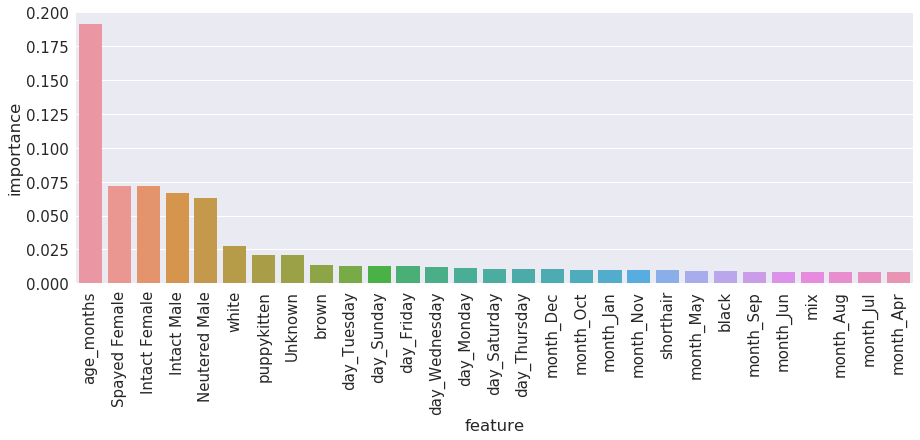

In [51]:
feature_importances = rf_classifier.feature_importances_
xnames=X_train.columns

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:30])

In [52]:
dfm.drop([ 21 , 39 , 66 , 73 , 74 , 77 , 97 ,116, 125 ,127 ,137 ,162 ,166 ,176 ,178 ,179 ,183 ,190
 ,191 ,205 ,243 ,245 ,264 ,297],axis=1,inplace=True)

In [53]:
%%time
feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=100, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 550 µs


In [54]:
%%time
prediction_model.fit(X_train_scaled, y_train)

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  64  71  92 109 118 120 162 163 165 166 170 177 178 191 228 246 278] are constant.
  UserWarning)
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


CPU times: user 1min 21s, sys: 1min 5s, total: 2min 27s
Wall time: 1min 13s


Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f07738c29b0>))],
       transfor...imators=100, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False))])

<IPython.core.display.Javascript object>

In [55]:
%%time
cv_score = cross_val_score(prediction_model, X_train_scaled, y_train, cv=3, scoring='accuracy')
cv_score

CPU times: user 2min 38s, sys: 2min 42s, total: 5min 21s
Wall time: 2min 18s


<IPython.core.display.Javascript object>

In [56]:
%%time
cv_predict_score = cross_val_predict(prediction_model, X_train_scaled, y_train, cv=3)

CPU times: user 2min 38s, sys: 2min 43s, total: 5min 22s
Wall time: 2min 18s


<IPython.core.display.Javascript object>

In [57]:
print(np.mean(cv_score))
print(accuracy_score(y_train, cv_predict_score))

0.7971750499388834
0.7955504310683682


In [58]:
%%time
rf_pred = prediction_model.predict(X_test_scaled)

CPU times: user 1.86 s, sys: 7.12 s, total: 8.98 s
Wall time: 554 ms


In [59]:
print(accuracy_score(y_test, rf_pred))

0.7906450626719658


In [60]:
%%time
param_grid={'n_estimators':[300,400,500],
           'max_features':[5,7,10,15],
           'max_depth':[10,12,14,16,18,20]
           }
rf_tune=RandomForestClassifier(class_weight='balanced_subsample')
grid=GridSearchCV(estimator=rf_tune, param_grid=param_grid, cv=3,n_jobs=-1,verbose=1)
model=grid.fit(X_train_scaled,y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  3.0min finished


CPU times: user 1min 14s, sys: 2.53 s, total: 1min 17s
Wall time: 3min 26s


<IPython.core.display.Javascript object>

In [61]:
optimised_random_forest = model.best_estimator_

In [62]:
grid.best_params_
print round(grid.best_score_,2)

0.82


In [63]:
rf_grid_pred = grid.predict(X_test_scaled)
print(round(accuracy_score(y_test, rf_grid_pred),2))

0.81


Normalized confusion matrix
[[0.92844784 0.07155216]
 [0.36416539 0.63583461]]


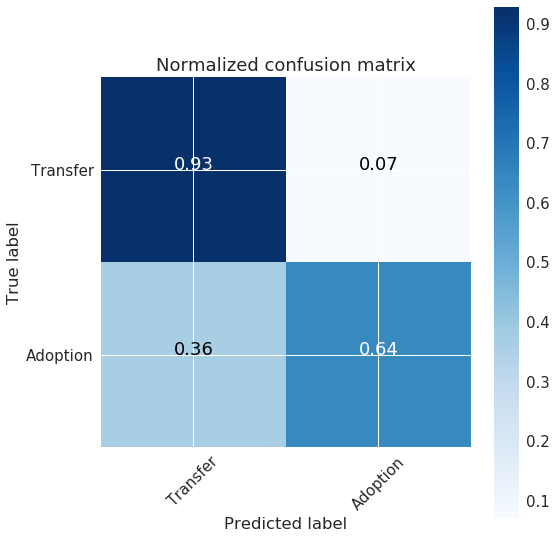

In [64]:
sns.set(font_scale=1.5)

rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)

plt.figure(figsize=(8, 8))

plot_confusion_matrix(rf_cnf_mat, classes=dfm.outcome_type.unique(), normalize=True, title='Normalized confusion matrix')

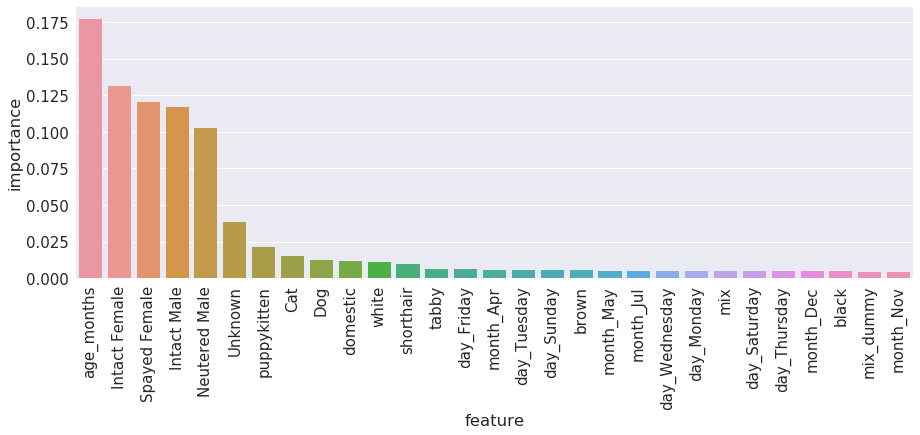

In [65]:
feature_importances = optimised_random_forest.feature_importances_
xnames=X_train.columns

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:30])

  # Summary

##### The chart above shows us what features our model consider important when deciding whether or not an animal will be adopted. We predicted with 82 percent accuracy what class an animal belongs to. The model indicates that age, whether or not an animal was neutered, specific months, and which colors and characteristics where important.